#  作業

Hint: 人物原始邊框座標 (60, 40), (420, 510)

請根據 Lena 圖做以下處理

- 對明亮度做直方圖均衡處理
- 水平鏡像 + 縮放處理 (0.5 倍)
- 畫出人物矩形邊框

In [1]:
import cv2
import numpy as np
from  matplotlib import pyplot as plt

img_path = 'data/Lenna.png'

# 以彩色圖片的方式載入
img = cv2.imread(img_path, cv2.IMREAD_COLOR)

In [2]:
# 顯示多張圖片
def plot_images_labels(images, labels):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    for i in range(0, len(images)):
        img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, len(images), 1 + i)
        ax.imshow(img)
        title = labels[i]
        ax.set_title(title, fontsize=10)

    plt.show()

## Hint: 矩形

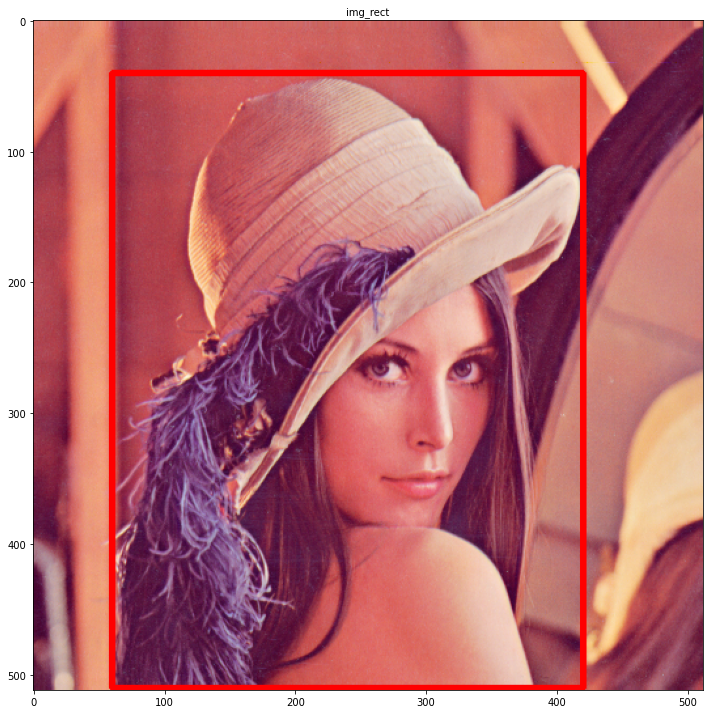

In [3]:
img_rect = img.copy()
cv2.rectangle(img_rect, (60, 40), (420, 510), (0, 0, 255), 3)


plot_images_labels([img_rect], ['img_rect'])

## Hint: 線

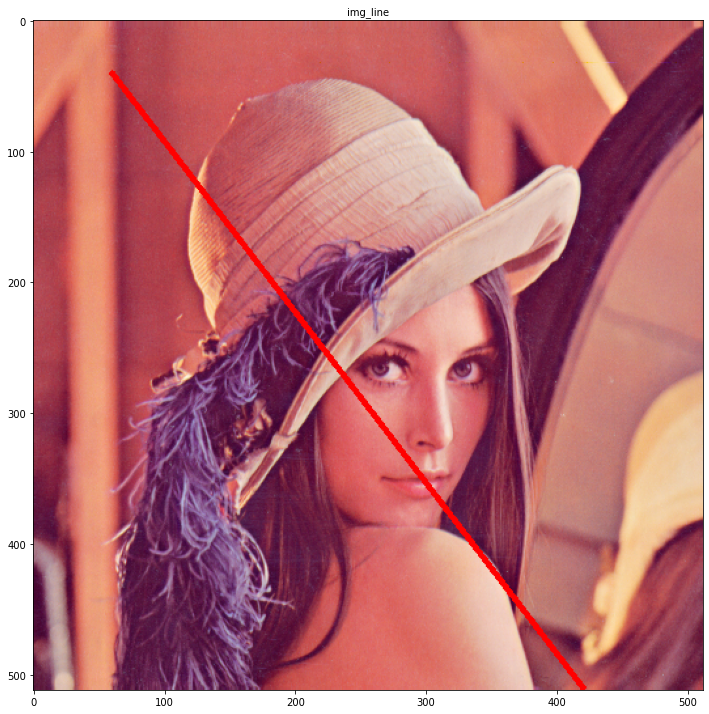

In [4]:
img_line = img.copy()
cv2.line(img_line, (60, 40), (420, 510), (0, 0, 255), 3)


plot_images_labels([img_line], ['img_line'])

## Hint: 文字

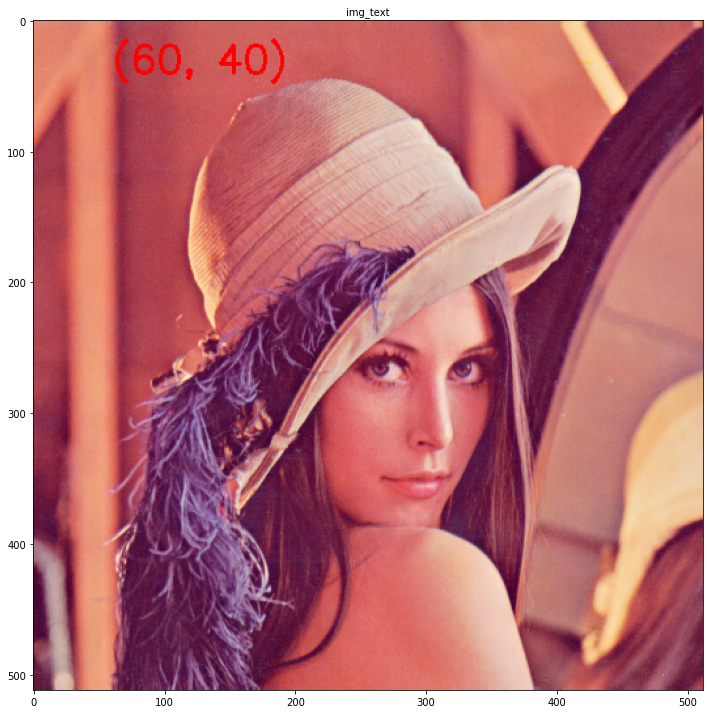

In [5]:
img_text = img.copy()
cv2.putText(img_text, '(60, 40)', (60, 40), 0, 1, (0, 0, 255), 2)

plot_images_labels([img_text], ['img_text'])

##  解法二

如果希望得知矩型邊框的位置

1. 顏色的操作 (對明亮度做直方圖均衡)
2. 鏡像可以透過四則運算得知
3. 透過建構 transformation matrix 做縮放
4. 把矩型邊框的點與 transformation matrix 相乘就會得到縮放後的位置
5. 畫圖

得到的圖的結果正確，同時也知道新的矩型邊框座標點

origin point1=[92, 40], origin point2=[452, 510]
resize point1=(46, 20), resize point2=(226, 255)


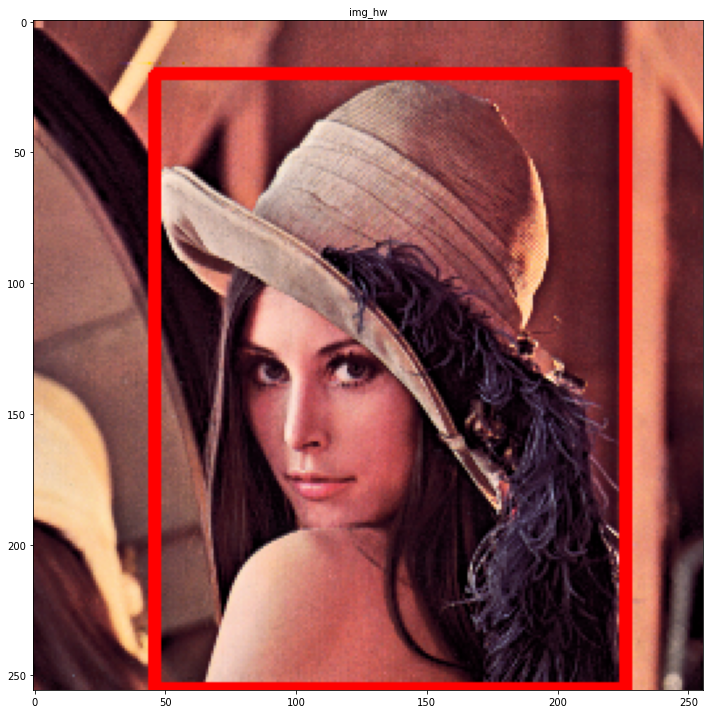

In [6]:
img_hw = img.copy()
point1 = [60, 40]
point2 = [420, 510]

"""
對明亮度做直方圖均衡
"""
# 原始 BGR 圖片轉 HSV 圖片
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_BGR2HSV)

# 對明亮度做直方圖均衡 -> 對 HSV 的 V 做直方圖均衡
img_hw[..., -1] = cv2.equalizeHist(img_hw[..., -1])

# 將圖片轉回 BGR
img_hw = cv2.cvtColor(img_hw, cv2.COLOR_HSV2BGR)

"""
水平鏡像
"""
h, w = img_hw.shape[:2]

# 圖片鏡像
img_hw = img_hw[:, ::-1, :]

# 透過四則運算計算鏡像後位置
# 確保點的位置一樣是左上跟右下，所以交換鏡像後的 x 座標 (y 座標做水平鏡像後位置不變)
point1[0] = w-point1[0]
point2[0] = w-point2[0]
point1[0], point2[0] = point2[0], point1[0]

"""
縮放處理 (0.5 倍)
"""
fx = 0.5
fy = 0.5
resize_col = int(img_hw.shape[1]*fx)
resize_row = int(img_hw.shape[0]*fy)

# 建構 scale matrix
M_scale = np.array([[0.5, 0, 0],
                    [0, 0.5, 0]], dtype=np.float32)
img_hw = cv2.warpAffine(img_hw, M_scale, (resize_col, resize_row))

# 把左上跟右下轉為矩陣型式
bbox = np.array((point1, point2), dtype=np.float32)
#print('M_scale.shape={}, bbox.shape={}'.format(M_scale.shape, bbox.shape))

# 做矩陣乘法可以使用 `np.dot`, 為了做矩陣乘法, M_scale 需要做轉置之後才能相乘
homo_coor_result = np.dot(M_scale.T, bbox)
homo_coor_result = homo_coor_result.astype('uint8')
#print(homo_coor_result)
scale_point1 = tuple(homo_coor_result[0])
scale_point2 = tuple(homo_coor_result[1])
print('origin point1={}, origin point2={}'.format(point1, point2))
print('resize point1={}, resize point2={}'.format(scale_point1, scale_point2))

# 畫圖
cv2.rectangle(img_hw, scale_point1, scale_point2, (0, 0, 255), 3)

plot_images_labels([img_hw], ['img_hw'])

##  解法三 (optional)

把矩型邊框用遮罩的方式呈現，使用同樣處理圖片的方式處理遮罩
最後再找遮罩的左上跟右下的點的位置

這邊會用到許多沒提過的東西，所以當作 optional